# Training a Feed-Forward Neural Network
*The code in this notebook can take some minutes to fully execute. Do not  worry if some cells are still executing after four to five minutes.*

## Introduction to the Case Study

**Business Context.** You are a computer security advisor with knowledge in Machine Learning from AI Integrated Services (fictitious name). This New York-based company provides Artificial Intelligence services and is looking for talent for one of its projects, real-time digits recognition.

**Business Problem.** The current techniques used to identify hand-written digits are based on the expert view, are not automated and depend on manual inputs from the expert. Besides being inefficient, this is causing an overloaded demand of manual processing that the company is not able to handle. The company wants to improve their manual processes including new algorithmic solutions on the Deep Learning space.

**Data context.** The data to be processed was obtained from a large number of digital contracts, currently available in the following files: `train-images`, `train-labels`, `test-images` and `test-labels`.

## Importing the packages for data analysis

We will use three main packages: `pandas`, `numpy`, and `matplotlib`. Let's import these packages using the `import` keyword. We will rename `pandas` to `pd`, `numpy` to `np`, and `matplotlib` to `plt`, using the `as` keyword.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time

from MNIST import MNIST_Reader
from DataLoader import MNIST_DataLoader

We will read a series of grayscale digital image files representing the digits of digital contracts, separated into training and testing data. Each data set consists of 28x28 digit grayscale images, stored as serialized `numpy` arrays. We will use the `MNIST` (specifically the `MNIST_Reader`) package provided to read and load the images.

Let's now instantiate the class and read the images of the digit 7:

In [2]:
training_set, testing_set = MNIST_Reader().load_images_from_digit(digit=7)

Let's check the size of the arrays containing the images:

In [3]:
print(training_set.shape, testing_set.shape)

(28, 28, 3132) (28, 28, 3133)


As we can see, we have 3132 training images and 313 testing images, all of them with a spatial resolution (size) of 28x28 pixels. Let's now look at three randomly selected images:

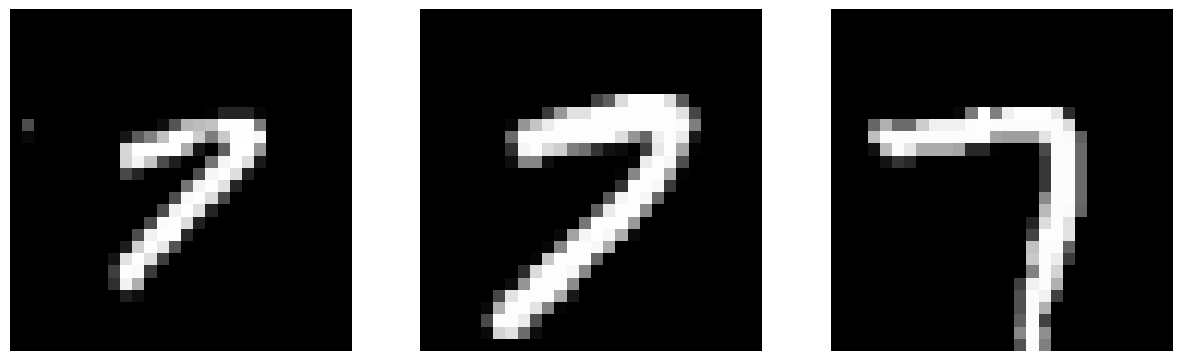

In [4]:
# Plot three images

image_indices = [1, 100, 1000]                       # Hand-picked image indices
fig, axes = plt.subplots(1,3,figsize=(15,100))       # Plottig three images in one row
plt.rcParams['image.cmap'] = 'gray'                  # Param defining grayscale images to be plotted
for idx,image_idx in enumerate(image_indices):       # Plotting the three images selected
    axes[idx].imshow(training_set[:,:,image_idx])
    axes[idx].axis('off')
plt.show()                                           # Showing the images in the plot

# Feed-Forward Neural Networks

### Building or first Feed-Forward Neural Network (FFNN) from scratch

Feed-forward Neural Networks are neural structures where:
- Connections go from a lower layer to a higher one.
- There are no connections between neurons of the same layer.
- There are no connections going from neurons of a higher layer to a lower one.

We will be using feed-forward neural networks to classify hundreds of handwritten digit images into their corresponding digits from 0 to 9 (10 unique categories).

To initialize a weight matrix constituting a feed-forward neural network, we can do the following:

In [5]:
input_dim   = 256                        # Number of inputs
output_dim  = 10                         # Number of outputs related to the number of unique digits to be classified

torch_vec   = torch.randn(input_dim)     # Initializing a vector with random numbers
first_layer = nn.Linear(input_dim,       # Creating the first layer of the neural network
                        output_dim, 
                        bias=True)
output      = first_layer(torch_vec)     # Creating the output linear combination

We are implicitly building a weight matrix having 10 rows and 256 columns that can also be empirically be built as:

```python
torch_vec = torch.randn(input_dim)                     # Initializing a vector with random numbers
weights   = torch.rand(10, 256)                        # Creating the matrix of weights
bias      = torch.zeros(10,1)                          # Creating the bias vector
output    = torch.matmul(weights, torch_vec) + bias    # Calculating the linear-combination output
```

So the `nn` module is abstracting all the complexity of building such weight matrices on a layer bases with a neural-structure implementation in the code. We can keep adding layers starting from the input one, going into the hidden layer and finally getting into the output layer. Since the classification problem involves 10 categories to be given as outputs an 26x26 values to be directly given as inputs, we will be having the following:

In [6]:
input_dim      = 28*28                        # Number of inputs
second_lay_dim = 256                          # Dimensions of the second layer
output_dim     = 10                           # Number of outputs related to the number of unique digits to be classified

torch_vec      = torch.randn(input_dim)       # Initializing a vector with random numbers
first_layer    = nn.Linear(input_dim,         # Creating the first layer of the neural network
                        second_lay_dim, 
                        bias=True)
second_layer   = nn.Linear(second_lay_dim,    # Creating the second layer of the neural network
                         output_dim, 
                         bias=True)
output = second_layer(first_layer(torch_vec)) # Creating the output linear combination

The neural structure we just created above is representing a compounded linear combination with the form: $W_2(W_1 * x + b_1) + b_2$. As you may recall, neural networks have non-linear activation functions such as sigmoid, tanh and ReLU. We can add those functions using the same neural structure as follows:

In [7]:
input_dim      = 28*28                        # Number of inputs
second_lay_dim = 256                          # Dimensions of the second layer
output_dim     = 10                           # Number of outputs related to the number of unique digits to be classified

torch_vec      = torch.randn(input_dim)       # Initializing a vector with random numbers
first_layer    = nn.Linear(input_dim,         # Creating the first layer of the neural network
                        second_lay_dim, 
                        bias=True)
second_layer   = nn.Linear(second_lay_dim,    # Creating the second layer of the neural network
                         output_dim, 
                         bias=True)

# Creating the output of layer 1, a ReLU activation function and layer 2:

relu_function  = nn.ReLU()                                     # Creating the relu function
output = second_layer(relu_function(first_layer(torch_vec)))   # Creating the output considering a ReLU function

So far we added input, hidden and output layers with activation functions, so we are almost done! The only thing we are missing is the **forward** and **backward** methods so that we can propagate the information throughout the neuron and minimize the error. This can be done by using the `nn.Module` class, which let us override the forward method as follows:

In [8]:
class BaseClassifier(nn.Module):
    def __init__(self, input_dim, feature_dim, output_dim):
        super(BaseClassifier, self).__init__()      # This avoids re-implementing initialization from nn.Module
        self.layer_1 = nn.Linear(input_dim,         # Creating the first layer of the neural network
                                 feature_dim, 
                                 bias=True)
        self.layer_2 = nn.Linear(second_lay_dim,    # Creating the second layer of the neural network
                         output_dim, 
                         bias=True)
        self.relu_function  = nn.ReLU()             # Creating the relu function
    
    def forward(self, x):                           # Foward method to propagate information
        x = self.layer_1(x.float())
        x = self.relu_function(x)
        output = self.layer_2(x)
        return output

Let's test this new implementation of the complete base classifier (`BaseClassifier`)!
We can test the implementation by instantiating the class and passing some random values:

In [9]:
n_observations  = 100                          # Defining a fictitious number of observations
input_dim       = 28*28                        # Number of inputs
feature_dim     = 256                          # Dimensions of the second layer
output_dim      = 10                           # Number of outputs related to the number of unique digits to be classified
x               = torch.randn((n_observations,input_dim))       # Creating our vector x

# Instantiating the base classifier
base_classifier = BaseClassifier(input_dim, feature_dim, output_dim)
output = base_classifier(x)
print(output.size())

torch.Size([100, 10])


In [10]:
x.shape

torch.Size([100, 784])

The final vector has 100 observations and 10 output values per observation, which is what we were expecting. This is a much clearer way of presenting the network in a neural-structure manner w.r.t. the implementation using matrix multiplication!

Now that the output is flowing through the network, we need a way of measuring the error, so a loss function is needed. We can use the Cross-entropy Loss to assess the model's performance. After calculating the loss, we will need to trace back the error and update the weights, in what we call the `backpropagation` process. Let's see how to implement these two:

In [11]:
cross_loss = nn.CrossEntropyLoss()                 # Instantiating the cross-entropy loss
target = torch.randint(0, 10, (n_observations,))   # Fictitious target values for the observations created
calc_loss = cross_loss(output, target)             # Calculating the loss
calc_loss.backward()                               # Executing the backpropagation

The only step that we are missing is to run the Gradient Descent to calculate the gradients and update the weights per layer. We can access the weights of the network by executing:

In [12]:
for param in base_classifier.parameters(): # Iterating over the classifier weights/parameters
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


This output can be grouped into two:
- The parameters of the first layer:
```python
torch.Size([256, 784])  # size of the weights
torch.Size([256])       # size of the bias term
```
- The parameters of the second layer:
```python
torch.Size([10, 256])   # size of the weights
torch.Size([10])        # size of the bias term
```

And we can execute the Gradient Descent (GD) by instantiating one of several optimizers. We will use the stochastic version of Gradient Descent (SGD), which finds the optimal values using groups of observations to make the parameter updates, as follows (you could also use Momentum-based optimization, second-order methods or even adaptative ones such as AdaGrad, RMSProp and Adam - more info about this optimizers [here](https://pytorch.org/docs/stable/optim.html)):

In [13]:
learning_rate = 0.001                                          # Defining the learning rate
sgd_optimizer = torch.optim.SGD(base_classifier.parameters(),  # Instantiating the optimizer using stochastic GD
                                lr=learning_rate)

To perform one step of stochastic Gradient Descent, we can simply run:

In [14]:
sgd_optimizer.step()       # Updates the weights through SGD
sgd_optimizer.zero_grad()  # Setting gradients to zero after the step above

We have all the steps that we need to start training a Neural Network. Let's export the complete dataset with images from all digits from 0 to 9. To do so, we will use the `MNIST_DataLoader` class within the `DataLoader` package. This class consumes data from our MNIST folder and sructures it for proper consumption. We just need to define the digits to be imported (`labels_input`) and the batch size (`batch_size`):

In [15]:
labels_input = [i for i in range(0,10)]    # The images from this digit labels will be imported
batch_size = 64                            # Size of the batch used to partition the data

# Importing the images from all digits mapped in labels_input
data_loader = MNIST_DataLoader(labels_input = labels_input)
training_set, testing_set, training_labels, testing_labels = data_loader.get_images()

Now, let's split the data into batches of 64 observations:

In [16]:
# Splitting the training and testing data into batches of 64 observaciones with their labels
training_set_batches, training_labels_batches = data_loader.split_batches(training_set, training_labels, batch_size = batch_size)
testing_set_batches, testing_labels_batches = data_loader.split_batches(testing_set, testing_labels, batch_size = batch_size)

# Iterating over the first five random batches of the training dataset
for idx, array in enumerate(training_set_batches[:5]):
        print(array.shape)                                        # Showing the shape of the training set per batch
        print(training_labels_batches[idx].shape, end='\n\n')     # Showing the shape of the labels array per batch

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)

(64, 1, 28, 28)
(64,)



Most of the batches will have 64 samples in their training/testing set and 64 target values in the labels' array. There are few batches that will have 63 samples due to the fact that the number of training samples is not a multiple of 64.

### Building the training and testing methods

So far, the steps above will be moving the search into each iteration, where new gradients will be calculated. However, executing all iterations manually with portions of the training set is quite inefficient, so far. To do that in a seamlessly way, we can formally define a training method as follows and the number of training iterations (`epochs`) as a fixed number:

In [17]:
input_dim       = 28*28                        # Number of inputs
feature_dim     = 256                          # Dimensions of the second layer
output_dim      = 10                           # Number of outputs related to the number of unique digits to be classified
learning_rate   = 0.001                        # Defining the learning rate
epochs          = 40                           # Defining the number of training iterations
loss_function   = nn.CrossEntropyLoss()        # Defining the loss function to be used

And now defining the training method that uses the parameters that we defined above:

In [18]:
def train(X_train, y_train,
          classifier = base_classifier,
          optimizer = sgd_optimizer,
          epochs = epochs,
          loss_function = loss_function, 
          verbose = True):

    """
    Training function.
    Inputs:
        - classifier: base classifier object to be used
        - optimizer: optimizer to be used to calculate the gradients
        - epochs: number of trainig iterations
        - loss_function: loss function object to be used to calculate training error
        - X_train: training samples formatted in batches
        - y_train: training labels formatted in batches
        - verbose: binary label to determine whether to print extra info or not
    Outputs:
        - None
    """

    classifier.train()                                            # Setting the model to train
    loss_list = []                                                # Defining the loss list to store the loss per epoch

    # Iterating over each epoch
    for epoch in range(epochs):
        running_loss = 0.0

        # Iterating over each minibatch
        for idx, array in enumerate(X_train):
            target = torch.tensor(y_train[idx]).long()            # Parsing the labels to a tensor
            data = torch.tensor(array).flatten(start_dim = 1)     # Flattening the minibatch to have 784 dimensions per observation
            output = classifier(data)                             # Calculating the output of the network for a given batch
            computed_loss = loss_function(output, target)         # Calculating the loss for a given minibatch
            computed_loss.backward()                              # Executing the backpropagation
            optimizer.step()                                      # Updating the weights through SGD one step ahead
            optimizer.zero_grad()                                 # Setting gradients to zero after the step above
            running_loss += computed_loss.item()                  # Keep track of cummulative loss of each minibatch
        loss_list.append(running_loss/len(X_train))               # Appending the loss per epoch in a list

        if verbose:
            print("Epoch: {}, Train loss: {}".format(epoch+1,     # Printing the epoch iteration id and the loss per epoch
                                                    running_loss/len(X_train)))

    # Plotting the loss per epoch during training
    plt.plot([i for i in range(1,epochs+1)], loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss - Learning rate {}".format(optimizer.defaults['lr']))
    plt.show()

In the training function defined above, we are iterating over each of the batches and moving the updates of the weights according to the gradients calculated. Every time we move, we update the weights and register the compounded loss. This will happen in each of the training iterations until reaching the ixed number of iterations defined in `epoch`.

Now that we know how training can be programmatically defined, let's see how to test the model:

In [19]:
def test(X_test, y_test,
         classifier = base_classifier, 
         loss_function = loss_function,
         batch_size = 64):
    """
    Training function.
    Inputs:
        - classifier: base classifier object to be used
        - loss_function: loss function object to be used to calculate testing error
        - X_test: testing samples formatted in batches
        - y_test: testing labels formatted in batches
        - batch_size: size of the batch
    Outputs:
        - final_loss: final loss after testing with all given observations
        - final_accuracy: final accuracy after testing with all given observations
    """
    
    classifier.eval()                                               # Setting the model to be tested
    accuracy = 0.0                                                  # Accuracy accumulator
    computed_loss = 0.0                                             # Loss accumulator

    with torch.no_grad():                                           # Telling PyTorch that we don't need gradients when testing
        for idx, array in enumerate(X_test):
            target = torch.tensor(y_test[idx]).long()               # Parsing the labels to a tensor
            data = torch.tensor(array).flatten(start_dim=1)         # Flattening the testing batch to have 784 dimensions per observation
            output = classifier(data)                               # Calculating the output of the network for a given batch
            _, preds = output.max(dim=1)                            # Getting the predicted label

            # Get loss and accuracy
            computed_loss += loss_function(output, target)          # Keep track of the cummulative loss of each batch
            accuracy += torch.sum(preds == target)                  # Calculating the total number of coinciding elements
        
        final_loss = computed_loss.item()/(len(X_test)*batch_size)  # Final loss calculation
        final_accuracy = accuracy*100.0/(len(X_test)*batch_size)    # Final accuracy calculation
        print("Test loss: {}, test accuracy: {}".format(            # Printing the final performance (loss & accuracy)
                    final_loss, final_accuracy))

    return final_loss, final_accuracy

As in training, in testing we iterate over each of the testing batches. However, this time we are not updating any weights nor executing training iterations. We are simply measuring the loss per batch and calculating the global loss of the classifier with all testing samples. We are also calculating the accuracy of the model, which is defined as how many samples is the model getting right from the total samples we gave in the testing.

### Training and testing our FFNN

After defining both training and testing methods, we are ready to train the base classifier (`base_classifier`) with the SGD optimizer (`sgd_optimizer`):

Epoch: 1, Train loss: 2.2515545521717844
Epoch: 2, Train loss: 2.1457654225038314
Epoch: 3, Train loss: 2.0226988123932372
Epoch: 4, Train loss: 1.8793040483491
Epoch: 5, Train loss: 1.7208136907264369
Epoch: 6, Train loss: 1.5577161713703862
Epoch: 7, Train loss: 1.4015564949019377
Epoch: 8, Train loss: 1.2610146701971352
Epoch: 9, Train loss: 1.140126130728325
Epoch: 10, Train loss: 1.038891611577097
Epoch: 11, Train loss: 0.9550029625262278
Epoch: 12, Train loss: 0.8854856676638507
Epoch: 13, Train loss: 0.827535135532493
Epoch: 14, Train loss: 0.7788084339993849
Epoch: 15, Train loss: 0.7374431265950966
Epoch: 16, Train loss: 0.7019903216916107
Epoch: 17, Train loss: 0.6713268638038432
Epoch: 18, Train loss: 0.6445851247193717
Epoch: 19, Train loss: 0.6210820633592382
Epoch: 20, Train loss: 0.6002778790907056
Epoch: 21, Train loss: 0.5817434421099071
Epoch: 22, Train loss: 0.5651341796810947
Epoch: 23, Train loss: 0.5501697778320516
Epoch: 24, Train loss: 0.5366229605573073
Epoch: 

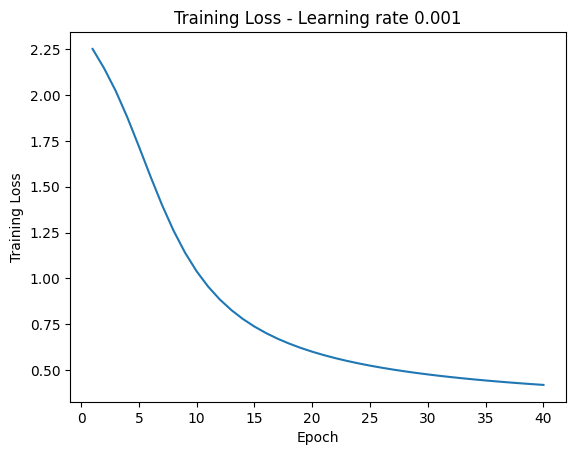

In [20]:
# Instatiating the base classifier and the Stochastic GD
base_classifier = BaseClassifier(input_dim, feature_dim, output_dim)
sgd_optimizer = torch.optim.SGD(base_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = base_classifier, optimizer = sgd_optimizer,
      X_train = training_set_batches, y_train = training_labels_batches)

As anticipated, the loss is decreasing as we execute each of the training iterations. Although this depends on the learning rate, the batch size and the training data, among others, we expected to see this downward trend, which is a sign of good fitting. Let's test the model with unseen examples and measure the final accuracy:

In [21]:
# Testing the model with unseen examples
final_loss, final_accuracy = test(classifier = base_classifier,
                                  X_test = testing_set_batches, 
                                  y_test = testing_labels_batches,
                                  batch_size = batch_size)

Test loss: 0.006571016840334894, test accuracy: 88.82595825195312


We can see thatthe model has an accuracy of around 89%; this means that out of the ~30,000 observations in the testing set, the model is able to identify around 27,000 correctly! 

### Zoom-in into some interesting testing examples

In the next code sections, we will now test different hyperparameter values. But first, let's see some cases were the model:
1. Classifies the data correctly and with high certainty
2. Classifies the data correctly, but with some uncertainty
3. Classifies the data incorrectly being uncertain about the output
4. Classifies the data incorrectly being certain about the output

In [22]:
# Testing method to facilitate the testing procedure
def test_and_plot(testing_sample, testing_label):
    target = torch.tensor(testing_label).long()                    # Parsing the labels to a tensor
    data = torch.tensor(testing_sample).flatten(start_dim=1)       # Flattening the testing batch to have 784 dimensions per observation
    output = base_classifier(data)                                 # Calculating the output of the network for a given batch
    probas = torch.nn.functional.softmax(output[0], dim=0)         # Getting the predicted likelihood using the softmax function
    
    print('Real value is', target.item())                          # Printing the real value
    print('Predicted value is {} with {}% probability'.format(     # Printing the predicted value and the likelihood
        probas.argmax().item(), 
        int((probas.max()*100).round().item())))

    # Plotting the real image at the left and the model probabilities for all output neurons at the right
    fig, axes = plt.subplots(1,2,figsize=(12,3))       
    axes[0].imshow(testing_sample[0])               # Ploting the real testing image
    axes[0].axis('off')
    axes[1].bar(labels_input,                       # Plotting the model probabilities for all output neurons
            probas.detach().numpy())
    axes[1].set_xticks(range(0,10))
    plt.show() 

---- Example: The classifier is correct and absolutely sure of the output ----
Real value is 0
Predicted value is 0 with 99% probability


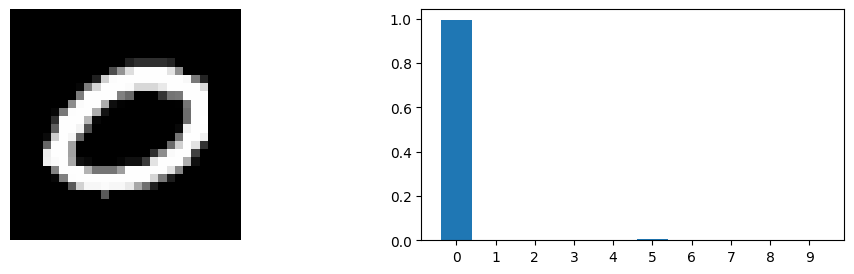

---- Example: The classifier is correct, but unsure about the output ----
Real value is 9
Predicted value is 9 with 61% probability


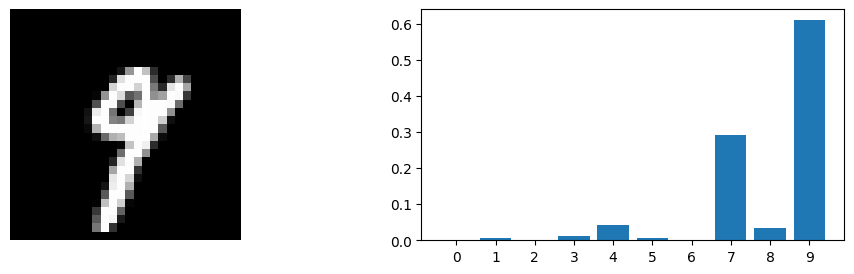

---- Example: The classifier is wrong and unsure about the output ----
Real value is 5
Predicted value is 4 with 46% probability


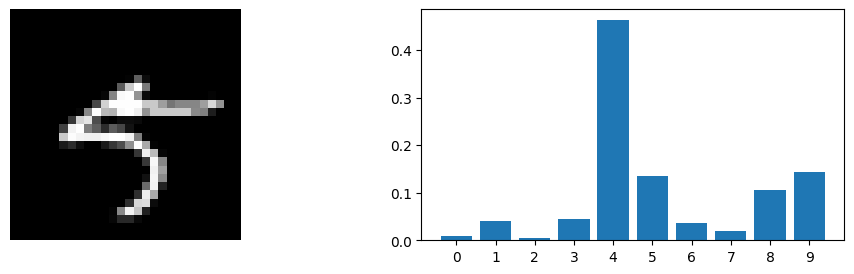

---- Example: The classifier is wrong and sure about the output ----
Real value is 9
Predicted value is 2 with 95% probability


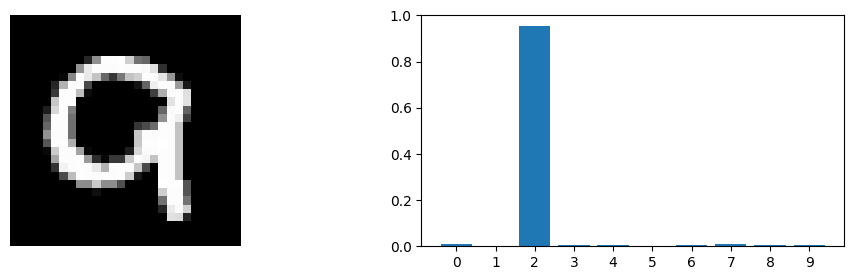

In [23]:
#   Dictionary of IDs according to the casses mapped above. The keys refer to (batch id, sample id in the batch)
## (0, 0)   -> The classifier is correct and absolutely sure of the output
## (0, 31)  -> The classifier is correct, but unsure about the output
## (0, 20)  -> The classifier is wrong and unsure about the output
## (36, 25) -> The classifier is wrong and sure about the output

idxs = {(0, 0):   'The classifier is correct and absolutely sure of the output',
        (0, 31):  'The classifier is correct, but unsure about the output',
        (0, 20):  'The classifier is wrong and unsure about the output',
        (36, 25): 'The classifier is wrong and sure about the output'}

# Iterating over each of the cases mapped above, plotting the real image and the model probabilities per output neuron
for idx in idxs:
    print('---- Example:', idxs[idx], '----')
    test_and_plot(testing_sample = testing_set_batches[idx[0]][idx[1]], 
                  testing_label = testing_labels_batches[idx[0]][idx[1]])

From the results above, we can see that, altough the model has a high accuracy for the testing samples, there are some observations with which the model is struggling with, such as the last two. The model might be unsure of the output and struggle to identify the targets (case 3), or it can even be very sure about the output and get the target wrong (this happens for less than 10 testing observations, so the percentage might be negligible - 0.03%).

### Testing different hyperparameters

So far, our optimizer was configured to have a learning rate of 0.001 with a batch size of 64 observations. However, these are two out of many hyperparameters that we could have defined. Let's see now what happens when we change the values of those hyperparamers. 

First, let's start by decreasing the learning rate from 0.001 to 0.0001:

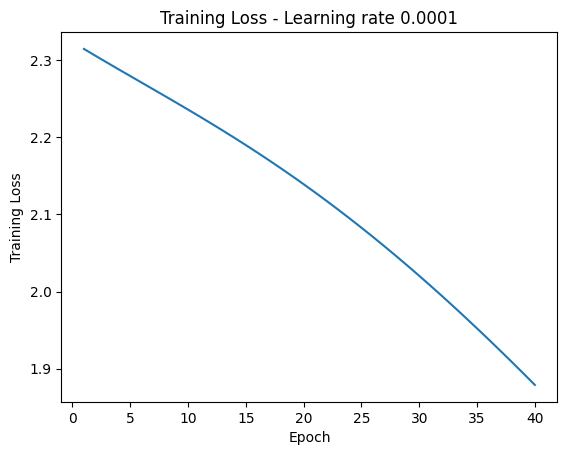

In [24]:
# Instatiating the base classifier and the Stochastic GD with a learning rate of 0.0001
learning_rate = 0.0001
base_classifier = BaseClassifier(input_dim, feature_dim, output_dim)
sgd_optimizer = torch.optim.SGD(base_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = base_classifier, optimizer = sgd_optimizer,
      X_train = training_set_batches, y_train = training_labels_batches,
      verbose=False)

With a very low learning rate, the model is underperforming and is not able to converge correctly into a local minima. This is am underfitting pattern and the model should not be used when this happens in production.

Let's see now what happens when the learning rate is too high:

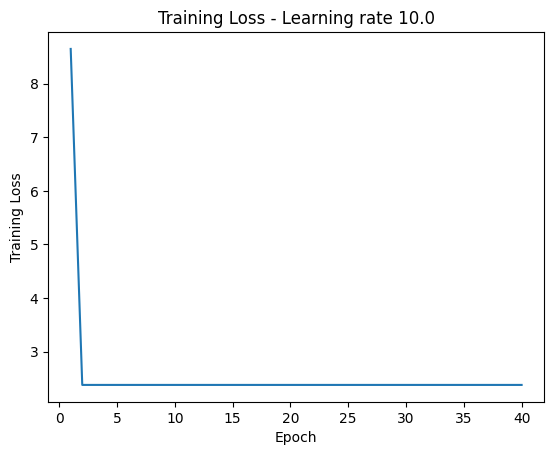

In [25]:
# Instatiating the base classifier and the Stochastic GD with a learning rate of 10.00
learning_rate = 10.00
base_classifier = BaseClassifier(input_dim, feature_dim, output_dim)
sgd_optimizer = torch.optim.SGD(base_classifier.parameters(), 
                                lr=learning_rate)

# Training the model instantiated above
train(classifier = base_classifier, optimizer = sgd_optimizer,
      X_train = training_set_batches, y_train = training_labels_batches,
      verbose = False)

As you can see from the graph above, when the learning rate is too high, some of the following scenarios migh happen:
- The training loss will start having sudden jumps because the gradient updates are too abrupt.
- The gradient won't move because a local minima was found in a saddle point.
Any of the two scenarios is a sign of underfitting due to overshooting or lack of conversion! Choosing the right learning rate is part of the hyperparameter optimization process that a model should go through before productionizing it.

Now, let's keep the learning rate at 0.001 and execute 10 epochs with batch sizes moving from 2 to 512 observations: 

Training with batch size 2:


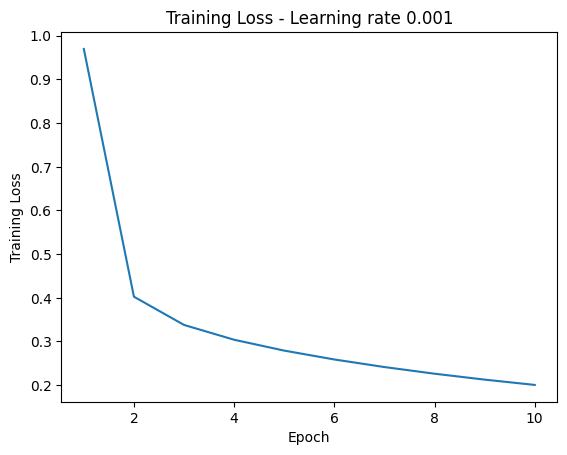

Test loss: 0.09932780512190396, test accuracy: 94.55963897705078


Training with batch size 4:


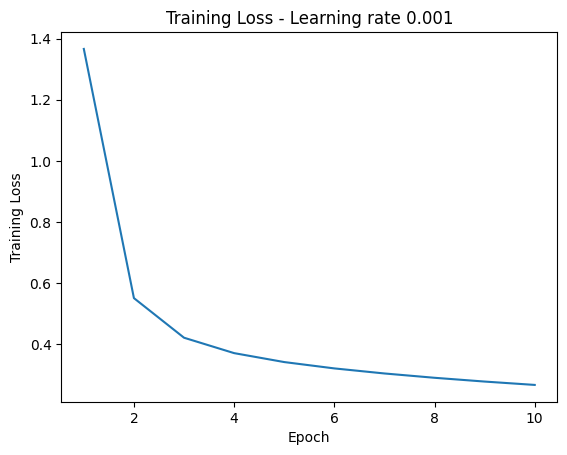

Test loss: 0.06657559407552083, test accuracy: 92.586669921875


Training with batch size 8:


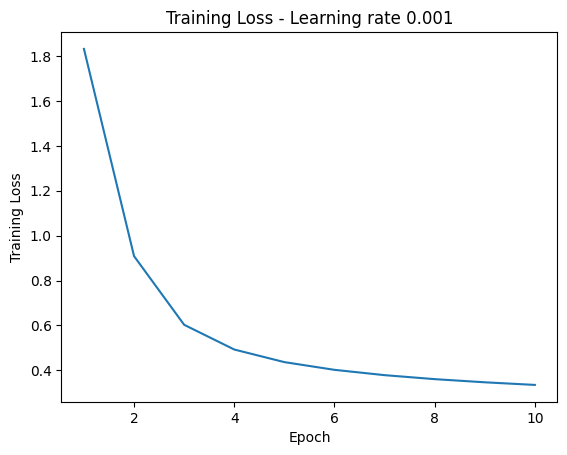

Test loss: 0.04171149088541667, test accuracy: 90.73999786376953


Training with batch size 16:


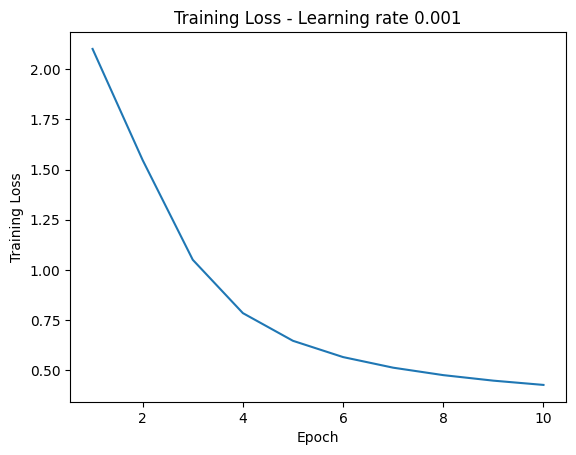

Test loss: 0.0262664306640625, test accuracy: 88.82666778564453


Training with batch size 32:


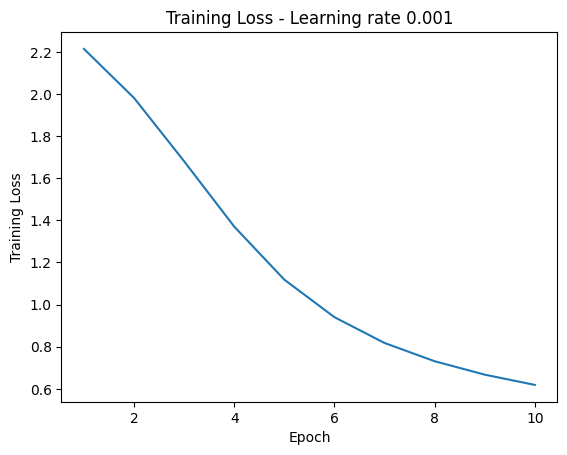

Test loss: 0.018759581071735698, test accuracy: 85.87419891357422


Training with batch size 64:


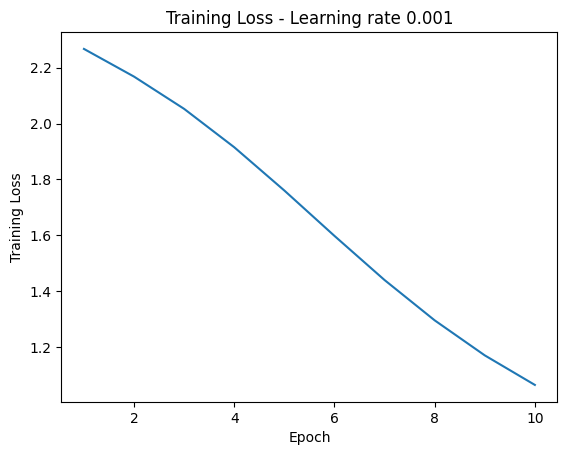

Test loss: 0.015939996186604122, test accuracy: 81.06010437011719


Training with batch size 128:


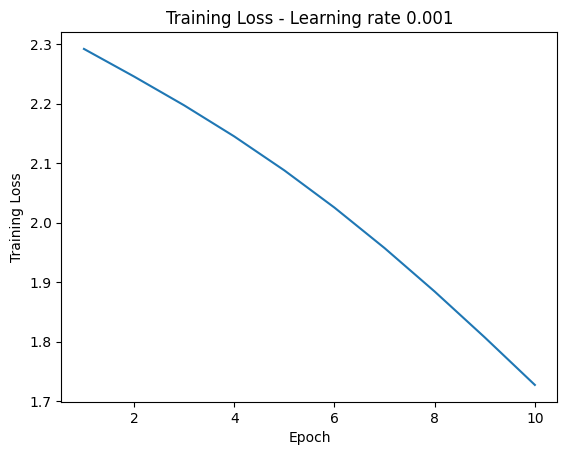

Test loss: 0.013178076642624876, test accuracy: 74.01927947998047


Training with batch size 256:


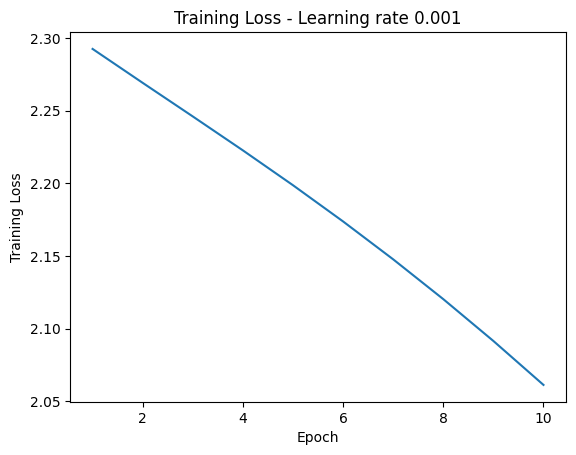

Test loss: 0.007990689600928354, test accuracy: 62.14910125732422


Training with batch size 512:


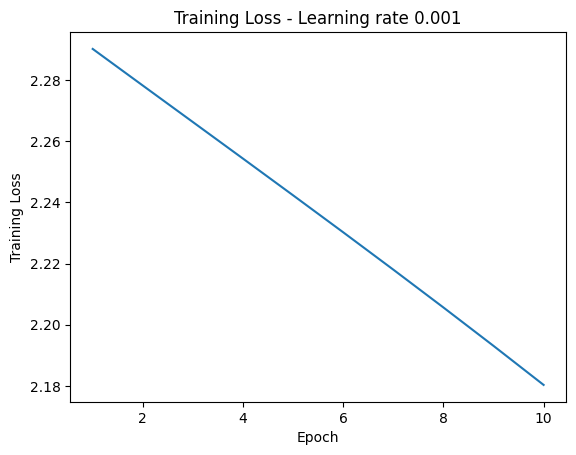

Test loss: 0.00424579442557642, test accuracy: 45.415122985839844




In [26]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512]   # Batch sized to test
times = []                                           # List definition to store the timelapses
accuracies = []                                      # List definition to store the accuracy for every batch size tested

# Iterating over each batch size from 2 to 512
for batch_size in batch_sizes:
    print('Training with batch size {}:'.format(batch_size))
    training_set_batches, training_labels_batches = data_loader.split_batches(training_set, training_labels, batch_size = batch_size)
    testing_set_batches, testing_labels_batches = data_loader.split_batches(testing_set, testing_labels, batch_size = batch_size)
    
    # Instatiating the base classifier and the Stochastic GD
    base_classifier = BaseClassifier(input_dim, feature_dim, output_dim)
    sgd_optimizer = torch.optim.SGD(base_classifier.parameters(), 
                                    lr=0.001)
    
    # Training the model instantiated above
    tic = time.time()
    train(classifier = base_classifier, optimizer = sgd_optimizer,
          X_train = training_set_batches, y_train = training_labels_batches,
          epochs = 10, verbose = False)
    toc = time.time()
    times += [toc-tic]
    
    # Testing the model with unseen examples
    final_loss, final_accuracy = test(classifier = base_classifier,
                                      X_test = testing_set_batches, 
                                      y_test = testing_labels_batches,
                                      batch_size = batch_size)
    accuracies += [final_accuracy]
    print('\n')

As we increase the batch size, the learning loss increases progressively in the last iteration of the process. In complement, as we approach a batch size of 128, the optimization has not converged, so 10 epochs might not be enough. As we have reviewed in the past, lower batch sizes might drive the process to a minimum very slowly on each iteration. Conversely, batches having several hundreds of samples might not converge in fewer iterations, although the time it takes to execute each iteration is lower. Let's see this relationship graphically (time during training and testing accuracy) w.r.t. the batch size:

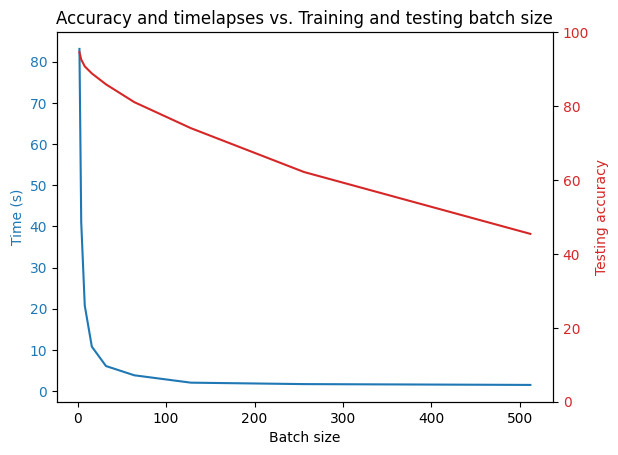

In [27]:
# Defining the first plotting object
fig, ax1 = plt.subplots()

# Ploting the timelapses in the vertical axis on the left
color = 'tab:blue'
ax1.set_xlabel('Batch size')
ax1.set_ylabel('Time (s)', color=color)
ax1.plot(batch_sizes, times, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Ploting the timelapses in the vertical axis on the right
color = 'tab:red'
ax2 = ax1.twinx()
ax2.set_ylabel('Testing accuracy', color=color)
ax2.plot(batch_sizes, accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 100])

# Showing the plot object
plt.title('Accuracy and timelapses vs. Training and testing batch size')
plt.show()

In the plot above we can see that having smaller batch sizes is beneficial for the model performance. Once we start increasing the batch size, the performance is decreasing until reaching a poing were the model is not better than a random decision. This might also be related to the number of epochs specified, since a model having a higher number of samples in the batch might require longer to converge.

In summary, choosing the architecture of the model, the optimizer and internal parameters is key when trying to develop a model wichin the good-fit spectrum of learning. Small modifications in the hyperparameters (such as the learning rate and the batch size) may cause a sever impact in the model performance.

## Lessons learned

- We learned how implement a Feed-Forward Neural Network (FFNN) from scratch using PyTorch, adding intpud, hidden and output layers with various dimensions, and read image data to be used in later processing.
- We learned how to transform the images into processable data that a FFNN can intake to generate meaningful outputs.
- We learned what is the impact of hyperparameters during the training and testing of FFNNs.